# hmm_inference
Evaluate HMM-boosted KWS inference using keyword similarity matrices.

In [2]:
from glob import glob

import os
os.chdir(r'C:\projects\malachor5')
import sys
import json
import torch
import numpy as np
from tqdm import tqdm
sys.path.append('scripts')
from hmm_utils import KeySimilarityMatrix, init_keyword_hmm
from kws import textgrid_to_df, timestamp_hits
from copy import deepcopy
from jiwer import cer, wer
import pandas as pd
from tqdm import tqdm
import seaborn as sns
kws_eval_files = glob(r"C:\projects\malachor5\data\keyword_search\tira_eval_kws\*.json")

c:\projects\malachor5\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\marks\AppData\Roaming\uv\python\cpython-3.12.10-windows-x86_64-none\Lib\inspect.py:1007: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):


Reload any changes made to local scripts

In [3]:
from importlib import reload
import kws
import hmm_utils
reload(kws)
reload(hmm_utils)
from hmm_utils import KeySimilarityMatrix, init_keyword_hmm
from kws import textgrid_to_df, timestamp_hits

In [4]:
file2matrices = {}
stems = set(os.path.basename(filepath).split('-')[0] for filepath in kws_eval_files)

get_window_len = lambda filepath: float(
    os.path.basename(filepath)
        .split('-')[1]
        .removesuffix('.json')
        .removesuffix('sec')
        .replace('_', '.')
)

for stem in tqdm(stems):
    stem_files = [filepath for filepath in kws_eval_files if stem in filepath]
    window_lens = set(get_window_len(filepath) for filepath in stem_files)
    file2matrices[stem]={}
    for window_len in tqdm(window_lens):
        file_with_len = [filepath for filepath in stem_files if get_window_len(filepath)==window_len][0]
        with open(file_with_len, encoding='utf8') as f:
            json_obj = json.load(f)
        sim_mat = torch.tensor(json_obj['similarity_matrix'])
        oov_probs = torch.tensor(json_obj['oov_probs'])
        file2matrices[stem][window_len]={}
        file2matrices[stem][window_len]['sim_mat']=sim_mat
        file2matrices[stem][window_len]['oov_probs']=oov_probs
        file2matrices[stem][window_len]['timestamps']=json_obj['timestamps']
        if 'keywords' not in file2matrices[stem]:
            file2matrices[stem]['keywords']=json_obj['keywords']

100%|██████████| 3/3 [00:11<00:00,  3.75s/it]


In [5]:
tgs = glob(r"C:\projects\malachor5\data\keyword_search\tira_eval_mfa_aligned\*.TextGrid")
for stem in stems:
    stem_tg = [tg for tg in tgs if stem in tg][0]
    file2matrices[stem]['textgrid']=stem_tg

In [6]:
kw_files = glob(r"C:\projects\malachor5\data\keyword_search\keyword_lists\*.txt")
for stem in stems:
    stem_kwfile = [kwfile for kwfile in kw_files if stem in kwfile][0]
    with open(stem_kwfile, encoding='utf8') as f:
        keyphrases = [x.strip() for x in f.readlines()]
    file2matrices[stem]['keyphrases']=keyphrases

In [7]:
stem = 'HH20220327n2'
keyphrases=file2matrices[stem]['keyphrases']
keywords=file2matrices[stem]['keywords']
timestamps=file2matrices[stem][0.5]['timestamps']
sim_mat=file2matrices[stem][0.5]['sim_mat']
oov_probs=file2matrices[stem][0.5]['oov_probs']
tg_path=file2matrices[stem]['textgrid']
tg_df=textgrid_to_df(tg_path)

In [8]:
ground_truth = torch.zeros_like(sim_mat)
for i, keyword in tqdm(enumerate(keywords), total=len(keywords)):
    ground_truth[:,i] = torch.tensor(timestamp_hits(tg_df, keyword, timestamps))

  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [03:13<00:00,  3.58s/it]


In [9]:
kw_idcs=ground_truth.argmax(dim=1)
kw_idcs[kw_idcs>0]

tensor([27, 27, 27,  ..., 29, 29, 29])

In [12]:
emission_mat=torch.concat([sim_mat, oov_probs[:,None]], dim=1).unsqueeze(0)
smx_col_mat=emission_mat.softmax(dim=2)
smx_row_mat=emission_mat.softmax(dim=1)
sig_mat=emission_mat.sigmoid()
smx_col_mat

tensor([[[0.0194, 0.0183, 0.0158,  ..., 0.0182, 0.0190, 0.0381],
         [0.0194, 0.0186, 0.0158,  ..., 0.0181, 0.0190, 0.0382],
         [0.0194, 0.0187, 0.0158,  ..., 0.0184, 0.0190, 0.0377],
         ...,
         [0.0193, 0.0191, 0.0158,  ..., 0.0180, 0.0193, 0.0383],
         [0.0194, 0.0196, 0.0155,  ..., 0.0179, 0.0190, 0.0379],
         [0.0196, 0.0189, 0.0156,  ..., 0.0179, 0.0186, 0.0389]]])

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report

lda = LinearDiscriminantAnalysis()
X = emission_mat.squeeze()
lda.fit(X, kw_idcs)
yhat = lda.predict(X)
class_labels = [keywords[i] for i in lda.classes_]
print(classification_report(yhat, kw_idcs, target_names=class_labels))
# len(keywords)

              precision    recall  f1-score   support

     lòɽgà       0.86      0.97      0.91      9569
      lùbó       0.83      0.33      0.48        15
   jìgèɲɔ́       0.43      0.41      0.42        22
      ɔ́ndì       0.71      0.43      0.53       110
   cícə̀lò       0.88      0.28      0.42        25
      kàŋú       0.55      0.39      0.45        70
      lɔ́mɔ̀       0.85      0.48      0.61        69
      kúkù       0.75      0.52      0.61       387
      cùbɔ̀       0.67      0.17      0.27        24
     ŋgìɲɔ́       0.39      0.31      0.34        49
     ŋòɽgà       0.75      0.15      0.25        20
      cə̀mú       1.00      0.14      0.25        14
       ɛ̀ðɛ̀       0.60      0.34      0.43        86
         nɛ̀       0.69      0.26      0.38       111
      lídɔ́       0.81      0.80      0.80       100
   kɛ̀gìɲɔ́       0.35      0.28      0.31        58
     ŋgèɲɔ́       0.66      0.38      0.48        60
         kà       0.67    

In [132]:
hmm_prefit, states = init_keyword_hmm(
    keyphrases,
    keywords,
    enter_prob = 0.01,      # default 0.1
    self_trans_prob = 0.5,  # default 0.5
    early_exit_prob = 0.01, # default 0.01
    late_enter_prob = 0.01, # default 0.01
)
hmm_bw = deepcopy(hmm_prefit)

In [133]:
def dedup_list(l):
    l_out = []
    prev_x = None
    for x in l:
        if x==prev_x:
            continue
        l_out.append(x)
        prev_x = x
    return l_out

# Grid search
HH20210913
First grid search:
- enter_prob on logscale from 0.01 to 0.2, 5 vals
- self_trans_prob on logscale from 0.1 to 0.9, 5 vals
- best value WER=0.96 at self-trans=0.519, enter_prob doesn't seem to have an effect

Second grid search:
- enter_prob on logscale from 0.4 to 0.6, 5 vals
- early exit and late enter prob on [0.001, 0.01, 0.1]
- best value WER=0.94 at self_trans=0.4, early exit/later enter don't seem to have an effect
HH20210312
- best value WER=0.896 at self_trans=0.4
HH20220327n2
- self_trans_prob on logscale from 0.3 to 0.7, 10 vals
- best value WER=

In [134]:
kw_str = ' '.join(str(x) for x in kw_idcs.tolist() if x!=0)
kw_dedup = ' '.join(str(x) for x in dedup_list(kw_idcs.tolist()) if x!=0)
scores = []

enter_prob = 0.1        # default 0.1
self_trans_prob = 0.5   # default 0.5
early_exit_prob = 0.01  # default 0.01
late_enter_prob = 0.01  # default 0.01

# for enter_prob in tqdm(np.logspace(np.log10(0.01), np.log10(0.2), num=5)):
# for early_exit_prob in [0.001, 0.01, 0.1]:
late_enter_prob = early_exit_prob
for self_trans_prob in tqdm(np.logspace(np.log10(0.3), np.log10(0.7), num=10)):
        hmm_prefit, states = init_keyword_hmm(
            keyphrases,
            keywords,
            enter_prob = enter_prob,
            self_trans_prob = self_trans_prob,
            early_exit_prob = early_exit_prob,
            late_enter_prob = late_enter_prob,
        )
        viterbi=hmm_prefit.viterbi(smx_row_mat)
        viterbi_str = ' '.join(str(x) for x in viterbi.squeeze().tolist() if x!=0)
        viterbi_dedup = ' '.join(str(x) for x in dedup_list(viterbi.squeeze().tolist()) if x!=0)
        wer_val=wer(kw_str, viterbi_str)
        wer_dedup=wer(kw_dedup, viterbi_dedup)
        scores.append({
            "wer": wer_val,
            "wer_dedup": wer_dedup,
            "enter_prob": enter_prob,
            "self_trans_prob": self_trans_prob,
            "early_exit_prob": early_exit_prob,
            "late_enter_prob": late_enter_prob,
        })
df = pd.DataFrame(scores)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [19:07<00:00, 114.80s/it]


In [142]:
df.corr()

,wer,wer_dedup,enter_prob,self_trans_prob,early_exit_prob,late_enter_prob
wer,1.000000,0.027559,NaN,0.606905,NaN,NaN
wer_dedup,0.027559,1.000000,NaN,-0.664711,NaN,NaN
enter_prob,NaN,NaN,NaN,NaN,NaN,NaN
self_trans_prob,0.606905,-0.664711,NaN,1.000000,NaN,NaN
early_exit_prob,NaN,NaN,NaN,NaN,NaN,NaN
late_enter_prob,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
df.sort_values(by='wer_dedup')

,wer,wer_dedup,enter_prob,self_trans_prob,early_exit_prob,late_enter_prob
4,7.084775,0.945652,0.1,0.437186,0.01,0.01
5,7.085928,0.959783,0.1,0.480344,0.01,0.01
3,7.078431,0.960870,0.1,0.397906,0.01,0.01
6,7.107843,0.976087,0.1,0.527763,0.01,0.01
7,7.098039,0.980435,0.1,0.579863,0.01,0.01
8,7.106690,0.984783,0.1,0.637106,0.01,0.01
9,7.107843,0.985870,0.1,0.700000,0.01,0.01
2,7.086505,1.123913,0.1,0.362154,0.01,0.01
0,7.099193,1.191304,0.1,0.300000,0.01,0.01
1,7.093426,1.227174,0.1,0.329615,0.01,0.01


<Axes: xlabel='self_trans_prob', ylabel='enter_prob'>

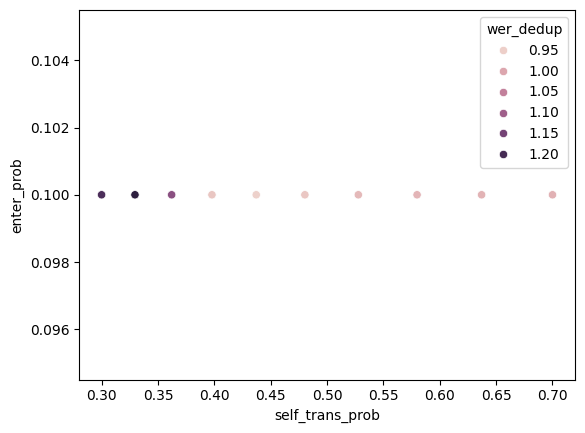

In [137]:
sns.scatterplot(df, x='self_trans_prob', y='enter_prob', hue='wer_dedup')

In [138]:
trans, responsibility, starts, ends, logprob = hmm_bw.forward_backward(smx_row_mat)

In [144]:
hmm_bw.fit(smx_row_mat)

SparseHMM(
  (start): Silent()
  (end): Silent()
  (distributions): ModuleList(
    (0-81): 82 x KeySimilarityMatrix()
  )
)

In [149]:
# viterbi=hmm_bw.viterbi(smx_col_mat)
kw_str = ' '.join(str(x) for x in dedup_list(kw_idcs.tolist()))
viterbi_str = ' '.join(str(x) for x in dedup_list(viterbi.squeeze().tolist()))
wer(kw_str, viterbi_str)

0.9986244841815681